#### Import Modules

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import yfinance as yf 
import smtplib 
import time
from datetime import datetime
import numpy as np

from datetime import datetime, date
import os
import pathlib

from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.message import EmailMessage
from email.mime.base import MIMEBase

#### Import ticker data

In [18]:
ticker =  'ETH-BTC'
data = yf.download(ticker, period='1y', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [19]:
period20MA = 20
period50MA = 50
data['20MA'] = data['Close'].rolling(window=period20MA, min_periods=1).mean()
data['50MA'] = data['Close'].rolling(window=period50MA, min_periods=1).mean()
data['Signal'] = 0.0
data['Signal'] = np.where(data['20MA'] > data['50MA'], 1.0, 0.0)
data['Position'] = data['Signal'].diff()

#### Plot Figure 

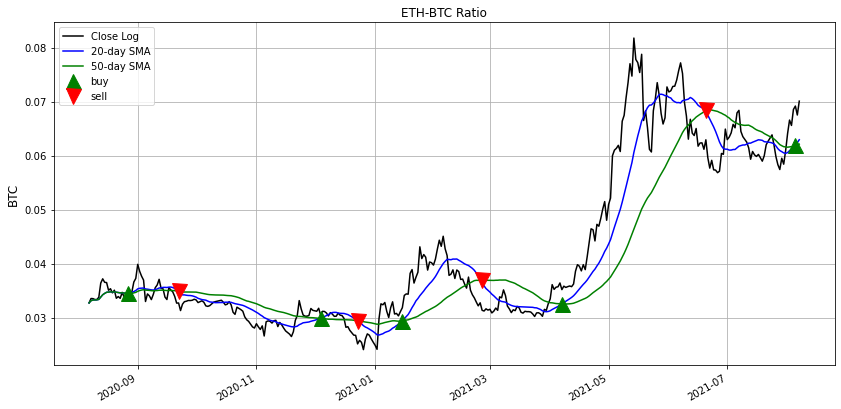

In [20]:
# Plotting Moving Average Signals
fig, ax = plt.subplots(figsize=(14, 7))
#plt.figure(figsize = (10,5))
# plot close price, short-term and long-term moving averages 
data['Close'].plot(color = 'k', label= 'Close Log') 
data['20MA'].plot(color = 'b',label = '20-day SMA') 
data['50MA'].plot(color = 'g', label = '50-day SMA')

# plot ‘buy’ signals

plt.plot(data[data['Position'] == 1].index,
         data['20MA'][data['Position'] == 1],'^', markersize = 15, color = 'g', label = 'buy')# plot ‘sell’ signals

plt.plot(data[data['Position'] == -1].index, 
         data['50MA'][data['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')

plt.ylabel('BTC', fontsize = 12)
plt.xlabel('', fontsize = 12)
plt.title(f'{ticker} Ratio', fontsize = 12)
plt.legend(loc='upper left')
plt.grid()


plt.show()

### save chart

In [21]:
filename = str(date.today()) + (f'{ticker}') + ".png"
dir = pathlib.Path(r'C:\\Users\\Jayde\\OneDrive\\Python\\Chart')
folder = r"\Chart"
path_plot = str(dir) + folder + filename
fig.savefig(path_plot, dpi=fig.dpi)

### import chart

In [22]:
filename = str(date.today()) + (f'{ticker}') + ".png"
dir = pathlib.Path(r'C:\\Users\\Jayde\\OneDrive\\Python\\Chart')
path_plot = str(dir) + folder + filename

### Message Conditions, Emails 

Define email function 

In [28]:
from_mail = "" #The sender email
to_mail = "" #The receiver email
from_password = ("") #The password to the sender email

In [29]:
smtp_server = "smtp.gmail.com"
smtp_port = 465

In [42]:
def send_email(path_plot, smtp_server, smtp_port, from_mail, from_password, to_mail, message):
    '''
        Send results via mail
    '''

    # Create the email message
    msg = MIMEMultipart()
    msg['Subject'] = f'{ticker} Daily Moving Average Report'
    msg['From'] = from_mail
    COMMASPACE = ', '
    msg['To'] = COMMASPACE.join([from_mail, to_mail])
    msg.preamble = f'{ticker} Daily Moving Average Report'

    # Open the files in binary mode and attach to mail
    with open(path_plot, 'rb') as fp:
        img = MIMEImage(fp.read())
        img.add_header('Content-Disposition', 'attachment', filename=f'{ticker}''.png')
        img.add_header('X-Attachment-Id', '0')
        img.add_header('Content-ID', '<0>')
        fp.close()
        msg.attach(img)

    # Attach HTML body
    msg.attach(MIMEText(message))

    # Send mail
    server = smtplib.SMTP_SSL(smtp_server, smtp_port)
    server.ehlo()
    server.login(from_mail, from_password)

    server.sendmail(from_mail, [from_mail, to_mail], msg.as_string())
    server.quit()


#### Messages

In [47]:
message_below_cross = "Death Cross \n20 Day Moving Average: " + str(data['20MA'][-1])  +  "\n50 Day Moving Average: " + str(data['50MA'][-1]) + '\nCurrent Ratio: ' + str(data['Close'][-1])
message_above_cross = 'Golden Cross \n20 Day Moving Average: ' + str(data['20MA'][-1])  +  "\n50 Day Moving Average: " + str(data['50MA'][-1]) + '\nCurrent Ratio: ' + str(data['Close'][-1])
current_price  = f'{ticker} Ratio: ' + str(data['Close'][-1])

#### Death Conditions

In [48]:
if data['Position'][-1] == -1.0 : #-1.0
    send_email(path_plot, smtp_server, smtp_port, from_mail, from_password, to_mail, message_below_cross)

#### Golden Conditions

In [49]:
if data['Position'][-1] == 1.0 : # 1.0
    send_email(path_plot, smtp_server, smtp_port, from_mail, from_password, to_mail, message_above_cross)

#### Current Price

In [50]:
if data['Position'][-1] == 0.0: # 1.0
    send_email(path_plot, smtp_server, smtp_port, from_mail, from_password, to_mail, current_price)